In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import MSELoss
import time

import warnings
warnings.filterwarnings("ignore")

from laser_jitter.data import TimeSeries, TimeSeriesSTFT
from laser_jitter.model_basic import LSTMForecaster
from laser_jitter.model import RNNTemporal, RNNSTFT
from laser_jitter.train import train_model
from laser_jitter.inference import predict_on_series

In [2]:
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

data = pd.read_csv("/home/wi73yus/focus_deviation/data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])

### TimeSeries

In [3]:
ts = TimeSeries(ts_data[:10000], smooth_params=smooth_params, train_size=0.8)

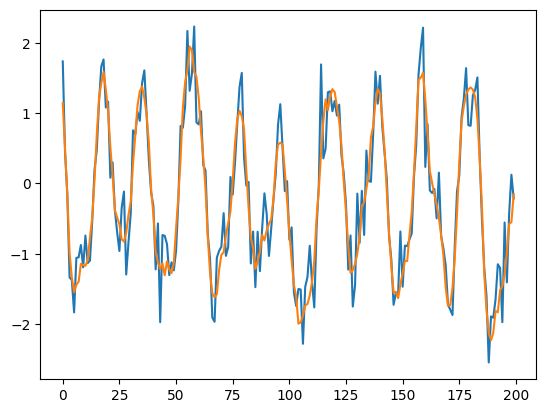

In [4]:
idx = 200
plt.figure()
plt.plot(ts.test[:idx])
plt.plot(ts.test_smooth[:idx])
plt.show()

In [5]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders
loaders_smooth = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                       dataloader_params)
trainloader_smooth, testloader_smooth = loaders_smooth

In [6]:
for (x,y), (x_smooth, y_smooth) in zip(trainloader, trainloader_smooth):
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 1]) torch.Size([64, 100, 1])


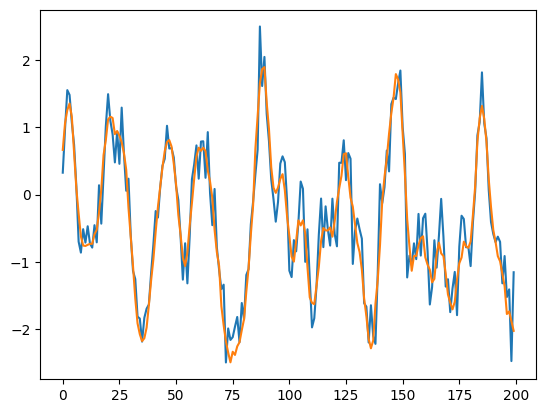

In [7]:
i = 50
idx = 200
plt.figure()
plt.plot(x[i,:idx])
plt.plot(x_smooth[i,:idx])
plt.show()

### TimeSeriesSTFT

In [15]:
stft_params = {
    'nperseg': 500, # window_length
    'fs': 1e3,
    'boundary': None,
    'noverlap': 499,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data[:10000], stft_params, train_size=0.8, filter_params=filter_params)

array([0.25 , 0.251, 0.252, ..., 7.748, 7.749, 7.75 ])

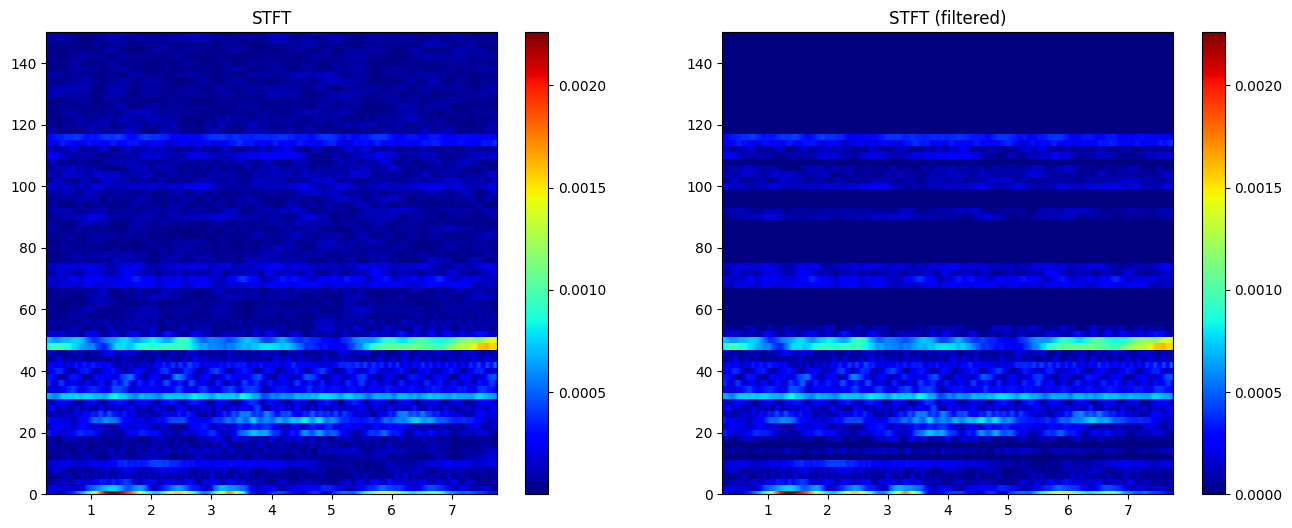

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT')


plt.subplot(122)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft_filt), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT (filtered)')
plt.show()

In [10]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [11]:
for x,y in trainloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 80]) torch.Size([64, 100, 80])


### Basic_model

In [24]:
n_features = 1
training_window = 200
prediction_window = 100
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
batch_size = 1

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': 128,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 3,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}

model = LSTMForecaster(**model_params)
x = torch.Tensor(np.random.uniform(size=(batch_size,training_window,n_features)))#.to(device)
print(x.shape)

prediction = model(x).detach().cpu().numpy()
prediction = prediction.reshape((batch_size,prediction_window,n_features))

print(prediction.shape)

torch.Size([1, 200, 1])
(1, 100, 1)


### Temporal model

In [3]:
smooth_params = {
    'kernel': np.ones(N)/N,
}

ts = TimeSeries(ts_data, smooth_params=smooth_params, train_size=0.8)

training_window = 200
prediction_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 128,
    'drop_last': False,
}

loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders

loaders = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                dataloader_params)
trainloader_smooth, testloader_smooth = loaders

In [4]:
n_features = 1
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 64,
    'n_hidden_fc': 500,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_path = 'models/rnn/rnn.pth'

model = LSTMForecaster(**model_params).to(device)
model_high_level = RNNTemporal(model_params, model, save_path)

In [5]:
lr = 2e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [6]:
losses = model_high_level.train(trainloader_smooth, testloader_smooth,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.46433043128591245, valid: 0.26156066460856076
1 - train: 0.25102246861632277, valid: 0.24233725512849874
2 - train: 0.23338137700305722, valid: 0.22628957649757123
3 - train: 0.21949822146718095, valid: 0.21699988122644095
4 - train: 0.20726543543784598, valid: 0.20584451998102254
5 - train: 0.19647504062187382, valid: 0.1989767487192976
6 - train: 0.18698253197883202, valid: 0.19032747529703994
7 - train: 0.17955627589206385, valid: 0.18628821599072423
8 - train: 0.17299265711288142, valid: 0.17889244212158795
9 - train: 0.1667201812189769, valid: 0.17626887302974176
10 - train: 0.16151035982903425, valid: 0.17231520753482293
11 - train: 0.1566057231852679, valid: 0.16844628905427866
12 - train: 0.15201616166083792, valid: 0.16669829215469031
13 - train: 0.1476506782256491, valid: 0.16525312744337936
14 - train: 0.1422830083505894, valid: 0.1665270266861751
15 - train: 0.13685383835459144, valid: 0.16504477786606755
16 - train: 0.13135916782103904, valid: 0.16352335415009

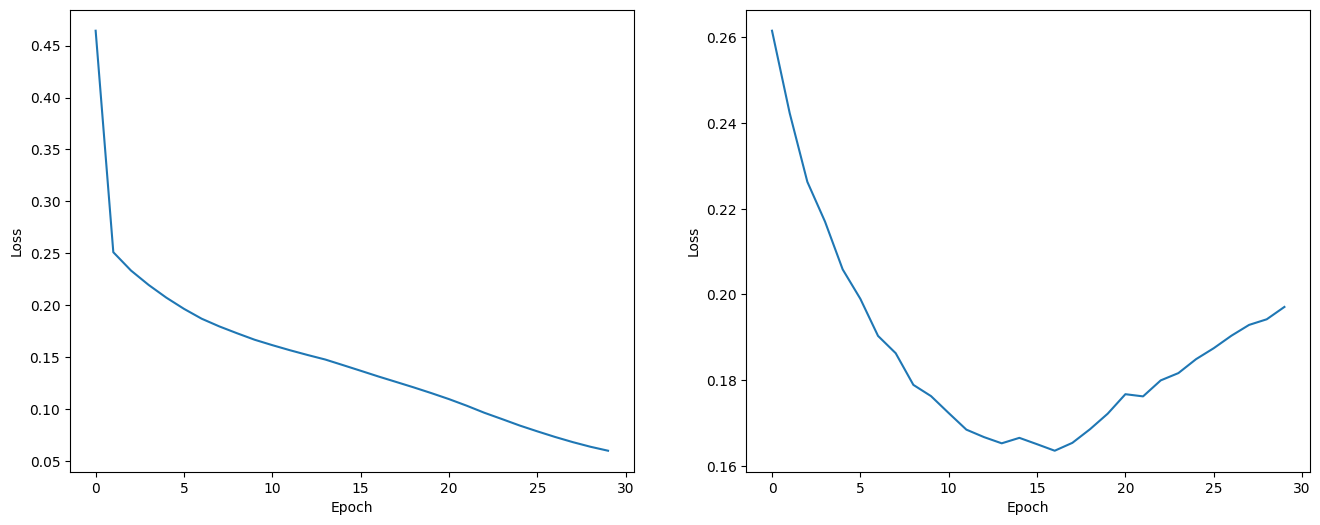

In [7]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

#### Inference

In [5]:
model = model_high_level.load_best_model()

data, metrics = model_high_level.inference_on_dataloader(model, testloader, testloader_smooth)
predictions, actuals, actuals_smooth = data
print(predictions.shape)

n_batches = len(predictions)
predictions = ts.inverse_transform_series(predictions.flatten())
predictions = predictions.reshape((n_batches,prediction_window))
actuals_smooth = ts.inverse_transform_series(actuals_smooth.flatten())
actuals_smooth = actuals_smooth.reshape((n_batches,prediction_window))
actuals = ts.inverse_transform_series(actuals.flatten(), scaler=ts.scaler)
actuals = actuals.reshape((n_batches,prediction_window))

metrics = [ts.inverse_transform_series(np.array([metric])).squeeze() for metric in metrics]

(3700, 100)


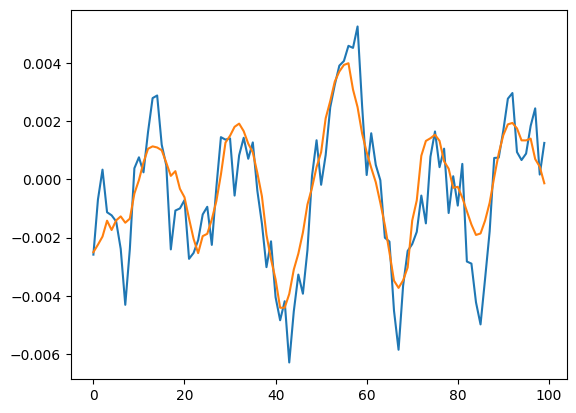

In [6]:
idx = 2500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [7]:
print(f'mae: {metrics[0]}')
print(f'rms: {metrics[1]}')

mae: 0.0010884532239288092
rms: 0.0013370062224566936


In [12]:
# use_cuda = torch.cuda.is_available()
models = []
save_path = 'models/rnn/rnn.pth'
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 64,
        'n_hidden_fc': 500,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = LSTMForecaster(**model_params).to(device)
    model_high_level = RNNTemporal(model_params, model, save_path)
    model_high_level.load_best_model()
    models.append(model_high_level)

In [15]:
t0 = 17500
N = 5

past_start, past_end = t0-N//2, t0+training_window+N//2 
future_start, future_end = t0+training_window+N//2, t0+training_window+N//2+prediction_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = predict_on_series(series_past, ts, models[i], device=device)
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 25.7 ms
Prediction time (cuda): 1.2 ms


rms (initial): 0.002468301142486467
rms          : 0.001860030718056792


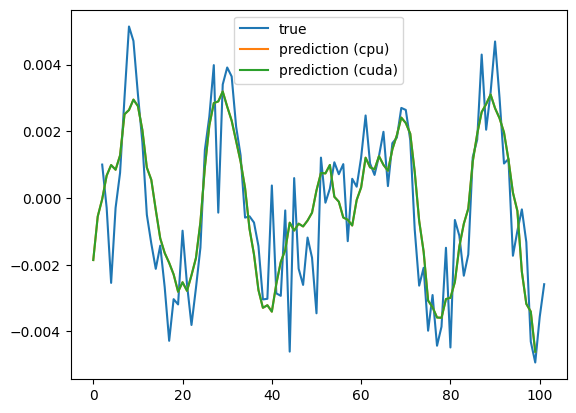

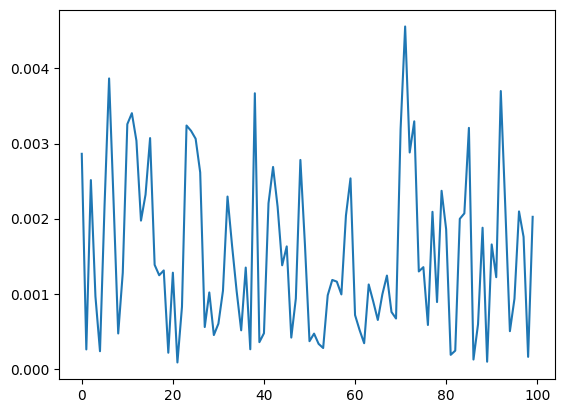

In [16]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(prediction_window)+2, series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

### Spectral model

In [19]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params)

training_window = 400
prediction_window = 150
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [23]:
n_features = len(ts.freq_filt)*2
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 64,
    'n_hidden_fc': prediction_window*3,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
model_type = 'single'
save_path = 'models/rnn_stft_test/'

model = None #LSTMForecaster(**model_params).to(device)
model_high_level = RNNSTFT(model_params, model_type, model, save_path)

In [21]:
lr = 1e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [22]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.7094711435910983, valid: 0.4773674581913238
1 - train: 0.3686952388439423, valid: 0.31922869828153166
2 - train: 0.24723580747078627, valid: 0.23896246577831023
3 - train: 0.17650413143838573, valid: 0.18807992513509506
4 - train: 0.12984919165953612, valid: 0.1572221243318091
5 - train: 0.09955860779453547, valid: 0.14144519431159852
6 - train: 0.0795563034967989, valid: 0.1371983766872832
7 - train: 0.0658757970469375, valid: 0.13611365791330945


KeyboardInterrupt: 

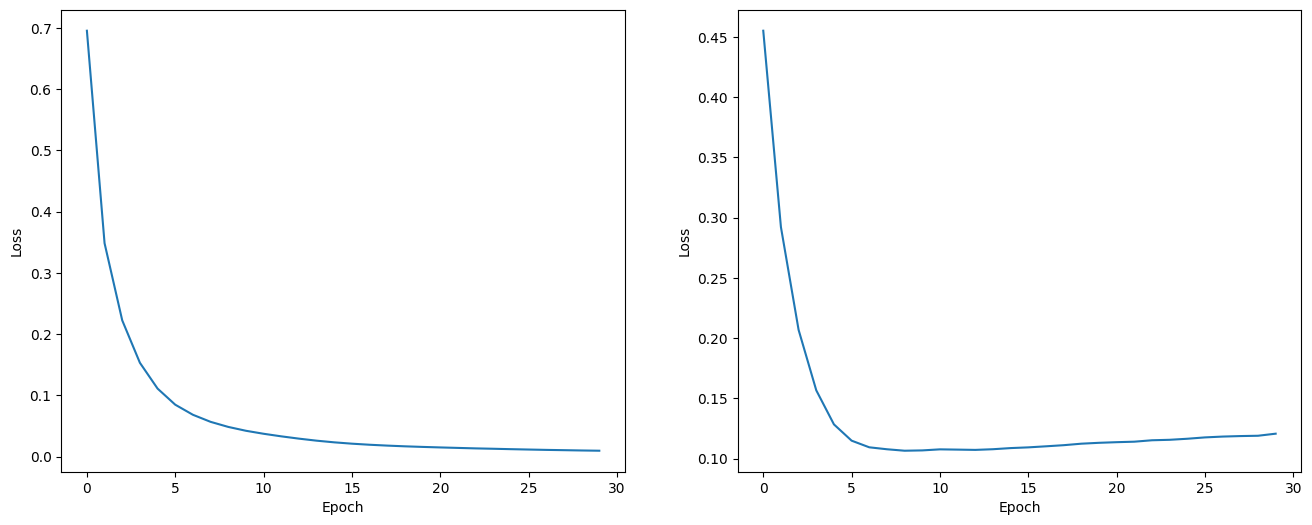

In [14]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

#### Inference

In [24]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]
print(test.shape)

(4000,)


In [25]:
data, metrics = model_high_level.inference_on_long_series(test, ts, sequence_params,
                                                          dataloader_params,
                                                          forecast_window)

In [26]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.0011486015282571316
rms: 0.0014404754620045424


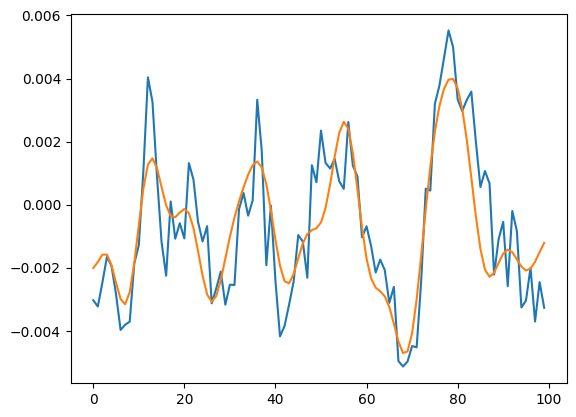

In [27]:
predictions, actuals = data

idx = 1000
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [ ]:
#TODO: Write a model that would take spectral features as input and output time-series